In [1]:
#Small Business Owners in the United States

# In this assignment, you're going to focus on business owners in the United States. You'll start by examining some demographic characteristics of the group, such as age, income category, and debt vs home value. Then you'll select high-variance features, and create a clustering model to divide small business owners into subgroups. Finally, you'll create some visualizations to highlight the differences between these subgroups. Good luck! 🍀

In [2]:
# Import libraries here
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [3]:
# Prepare Data
# Import
# Let's start by bringing our data into the assignment.

# Task 6.5.1: Read the file "data/SCFP2019.csv.gz" into the DataFrame df.

In [4]:
df = pd.read_csv("SCFP2019.csv")
print("df shape:", df.shape)
df.head()

df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


In [5]:
# Explore
# As mentioned at the start of this assignment, you're focusing on business owners. But what percentage of the respondents in df are business owners?

# Task 6.5.2: Calculate the proportion of respondents in df that are business owners, and assign the result to the variable pct_biz_owners. You'll need to review the documentation regarding the "HBUS" column to complete these tasks.

In [6]:
pct_biz_owners = df["HBUS"].value_counts(normalize=True).min()
print("proportion of business owners in df:", pct_biz_owners)

proportion of business owners in df: 0.2740176562229531


In [7]:
# Is the distribution of income different for business owners and non-business owners?

In [8]:
df["INCCAT"]

0        3
1        3
2        3
3        2
4        3
        ..
28880    6
28881    6
28882    6
28883    6
28884    6
Name: INCCAT, Length: 28885, dtype: int64

In [9]:
# Task 6.5.3: Create a DataFrame df_inccat that shows the normalized frequency for income categories for business owners and non-business owners. Your final DataFrame should look something like this:

#     HBUS   INCCAT  frequency
# 0      0     0-20   0.210348
# 1      0  21-39.9   0.198140
# ...
# 11     1     0-20   0.041188

In [10]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

df_inccat = df["INCCAT"].replace(inccat_dict).groupby(df["HBUS"]).value_counts(normalize=True).rename("frequency").to_frame().reset_index()

df_inccat

,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


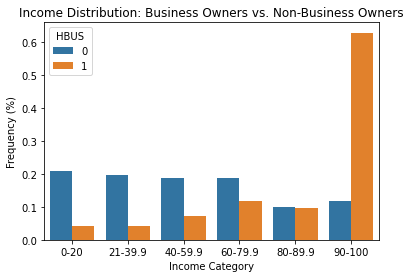

In [11]:
# Create bar chart of `df_inccat`
sns.barplot(
    x= "INCCAT",
    y="frequency",
    hue="HBUS",
    data=df_inccat,
    order=inccat_dict.values()
)
plt.xlabel("Income Category"),
plt.ylabel("Frequency (%)"),
plt.title("Income Distribution: Business Owners vs. Non-Business Owners")
# Don't delete the code below 👇
plt.savefig("images/income_distro.png", dpi=150)


In [12]:
# We looked at the relationship between home value and household debt in the context of the the credit fearful, but what about business owners? Are there notable differences between business owners and non-business owners?

# Task 6.5.5: Using seaborn, create a scatter plot that shows "HOUSES" vs. "DEBT". You should color the datapoints according to business ownership. Be sure to label the x-axis Household Debt, the y-axis Home Value, and use the title Home Value vs. Household Debt.

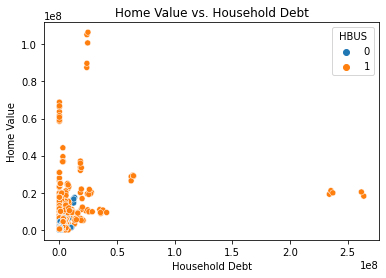

In [13]:
 # Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x="DEBT",
    y="HOUSES",
    hue="HBUS",
    data=df
)
plt.xlabel("Household Debt"),
plt.ylabel("Home Value"),
plt.title("Home Value vs. Household Debt")
# Don't delete the code below 👇
plt.savefig("images/scatter_plt_houseDebt.png", dpi=150)


In [14]:
# For the model building part of the assignment, you're going to focus on small business owners, defined as respondents who have a business and whose income does not exceed $500,000.

In [15]:
df["INCOME"]

0         67195.781504
1         57014.602488
2         51924.012980
3         41742.833964
4         50905.895078
             ...      
28880    411319.632230
28881    410301.514330
28882    379757.977290
28883    430663.872360
28884    402156.571120
Name: INCOME, Length: 28885, dtype: float64

In [16]:
# 6: Create a new DataFrame df_small_biz that contains only business owners whose income is below $500,000.

In [17]:
mask = (df["INCOME"] < 500_000) & (df["HBUS"] == 1)
df_small_biz = df[mask]
print("df_small_biz shape:", df_small_biz.shape)
df_small_biz.head()

df_small_biz shape: (4364, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


In [18]:
# We saw that credit-fearful respondents were relatively young. Is the same true for small business owners?

# Task 6.5.7: Create a histogram from the "AGE" column in df_small_biz with 10 bins. Be sure to label the x-axis "Age", the y-axis "Frequency (count)", and use the title "Small Business Owners: Age Distribution".

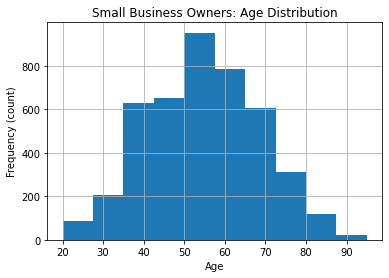

In [19]:
# Plot histogram of "AGE"
df_small_biz["AGE"].hist(bins=10)
plt.xlabel("Age")
plt.ylabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution");
# Don't delete the code below 👇
plt.savefig("images/6-5-7.png", dpi=150)


In [20]:
# So, can we say the same thing about small business owners as we can about credit-fearful people?

In [21]:
# Let's take a look at the variance in the dataset.

# Task 6.5.8: Calculate the variance for all the features in df_small_biz, and create a Series top_ten_var with the 10 features with the largest variance.

In [22]:
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz.var().sort_values().tail(10)
top_ten_var

EQUITY      1.005088e+13
FIN         2.103228e+13
KGBUS       5.025210e+13
ACTBUS      5.405021e+13
BUS         5.606717e+13
KGTOTAL     6.120760e+13
NHNFIN      7.363197e+13
NFIN        9.244074e+13
NETWORTH    1.424450e+14
ASSET       1.520071e+14
dtype: float64

In [23]:
# We'll need to remove some outliers to avoid problems in our calculations, so let's trim them out.

# Task 6.5.9: Calculate the trimmed variance for the features in df_small_biz. Your calculations should not include the top and bottom 10% of observations. Then create a Series top_ten_trim_var with the 10 features with the largest variance.

In [24]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var).sort_values().tail(10)
top_ten_trim_var

EQUITY      1.177020e+11
KGBUS       1.838163e+11
FIN         3.588855e+11
KGTOTAL     5.367878e+11
ACTBUS      5.441806e+11
BUS         6.531708e+11
NHNFIN      1.109187e+12
NFIN        1.792707e+12
NETWORTH    3.726356e+12
ASSET       3.990101e+12
dtype: float64

In [25]:
# Let's do a quick visualization of those values.

# Task 6.5.10: Use plotly express to create a horizontal bar chart of top_ten_trim_var. Be sure to label your x-axis "Trimmed Variance [$]", the y-axis "Feature", and use the title "Small Business Owners: High Variance Features".

In [26]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="Small Business Owners: High Variance Features"
)
fig.update_layout(xaxis_title="Trimmed Variance [$]", yaxis_title="Feature")
# Don't delete the code below 👇
fig.write_image("images/6-5-10.png", scale=1, height=500, width=700)

fig.show()

In [27]:
# Based on this graph, which five features have the highest variance?

# Task 6.5.11: Generate a list high_var_cols with the column names of the five features with the highest trimmed variance.

In [28]:
high_var_cols = top_ten_trim_var.tail(5).index.to_list()
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

In [29]:
# Split
# Let's turn that list into a feature matrix.

# Task 6.5.12: Create the feature matrix X. It should contain the five columns in high_var_cols.

In [30]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)

X shape: (4364, 5)


In [31]:
# Build Model
# Now that our data is in order, let's get to work on the model.

# Iterate
# Task 6.5.13: Use a for loop to build and train a K-Means model where n_clusters ranges from 2 to 12 (inclusive). Your model should include a StandardScaler. Each time a model is trained, calculate the inertia and add it to the list inertia_errors, then calculate the silhouette score and add it to the list silhouette_scores.

In [32]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
   # Build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    
    # Train model
    model.fit(X)
    
    # Calculate Inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate silhoute
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )

print("Inertia:", inertia_errors[:3])
print()
print("Silhouette Scores:", silhouette_scores[:3])

Inertia: [5765.863949365048, 3070.4294488357455, 2220.292185089684]

Silhouette Scores: [0.9542706303253067, 0.8446503900103915, 0.7422220122162623]


In [33]:

# Just like we did in the previous module, we can start to figure out how many clusters we'll need with a line plot based on Inertia.

# Task 6.5.14: Use plotly express to create a line plot that shows the values of inertia_errors as a function of n_clusters. Be sure to label your x-axis "Number of Clusters", your y-axis "Inertia", and use the title "K-Means Model: Inertia vs Number of Clusters".

In [34]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
# Don't delete the code below 👇
fig.write_image("images/line_plt_InerClus.png", scale=1, height=500, width=700)

fig.show()

In [35]:
# That's the right answer. Keep it up!

# Score: 1

# And let's do the same thing with our Silhouette Scores.

# Task 6.5.15: Use plotly express to create a line plot that shows the values of silhouette_scores as a function of n_clusters. Be sure to label your x-axis "Number of Clusters", your y-axis "Silhouette Score", and use the title "K-Means Model: Silhouette Score vs Number of Clusters".

In [36]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(x=n_clusters, y=silhouette_scores, title="K-Means Model: Silhoutter Score vs Number of Clusters")
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")
# Don't delete the code below 👇
fig.write_image("images/line_plt_SilClus.png", scale=1, height=500, width=700)

fig.show()

In [37]:
# Build and train a new k-means model named final_model. The number of clusters should be 3.

In [38]:
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=42))
final_model.fit(X)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

In [39]:
# Communicate
# Excellent! Let's share our work!

# Task 6.5.17: Create a DataFrame xgb that contains the mean values of the features in X for the 3 clusters in your final_model.

In [40]:
labels = final_model.named_steps["kmeans"].labels_
xgb = X.groupby(labels).mean()
xgb

,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,7.367185e+05,1.002199e+06,1.487967e+06,2.076003e+06,2.281249e+06
1,6.874479e+07,8.202115e+07,9.169652e+07,1.134843e+08,1.167529e+08
2,1.216152e+07,1.567619e+07,1.829123e+07,2.310024e+07,2.422602e+07


In [41]:
# As usual, let's make a visualization with the DataFrame.

# Task 6.5.18: Use plotly express to create a side-by-side bar chart from xgb that shows the mean of the features in X for each of the clusters in your final_model. Be sure to label the x-axis "Cluster", the y-axis "Value [$]", and use the title "Small Business Owner Finances by Cluster".

In [42]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Small Business Owner Finances by Cluster"
)
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")
# Don't delete the code below 👇
fig.write_image("images/small_biz_owners.png", scale=1, height=500, width=700)

fig.show()

In [43]:
# Remember what we did with higher-dimension data last time? Let's do the same thing here.

# Task 6.5.19: Create a PCA transformer, use it to reduce the dimensionality of the data in X to 2, and then put the transformed data into a DataFrame named X_pca. The columns of X_pca should be named "PC1" and "PC2".

In [44]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4364, 2)


,PC1,PC2
0,-6.220648e+06,-503841.638838
1,-6.222523e+06,-503941.888901
2,-6.220648e+06,-503841.638839
3,-6.224927e+06,-504491.429465
4,-6.221994e+06,-503492.598399


In [45]:
# Finally, lets make a visualization of our final DataFrame.

# Task 6.5.20: Use plotly express to create a scatter plot of X_pca using seaborn. Be sure to color the data points using the labels generated by your final_model. Label the x-axis "PC1", the y-axis "PC2", and use the title "PCA Representation of Clusters".

In [46]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="PCA Representation of Clusters"
    
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
# Don't delete the code below 👇
fig.write_image("images/scatter_PC2vPC1.png", scale=1, height=500, width=700)

fig.show()